In [45]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = "DW_2000Q_2_1"
api_key = 'DEV-3142f58be13a0aacd44657b15b8fb9832ba3bdac'

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [49]:
# Import data

dataset = 'sectors' # values: 'asset_class','ftse','sectors','sp100'

corr_tensor = np.load('../Data/%s/%s_corr.npy' % (dataset, dataset))
dates = np.load('../Data/%s/%s_dates.npy' % (dataset, dataset))
nodes = np.load('../Data/%s/%s_nodes.npy' % (dataset, dataset))
nodes_descr = np.load('../Data/%s/%s_nodes_descr.npy' % (dataset, dataset))

num_examples = corr_tensor.shape[0]
dim = corr_tensor.shape[1]

In [47]:
print("num examples: %d, matrix dim: %d" % (num_examples, dim))

num examples: 120, matrix dim: 21


In [48]:
# Helper Functions

def make_graph(corr_mat, node_labels, graph_type):

    G = nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not = corr matrix dimensions')

    if graph_type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    if graph_type=='corr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] != 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    if graph_type=='uncorr':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] == 0.000:
                    G.add_edge(node_labels[i], node_labels[j])
    
    density = (2*G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes() - 1))
                
    return G, density

def get_max_deg(G):
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

    return max(degree_sequence)

def coloring_score(G, coloring):
    count = 0
    for e in G.edges():
        v1, v2 = e
        if coloring[v1] == coloring[v2]:
            count += 1
        
        return count/G.number_of_edges()

In [30]:
# Test to see if DW comp. is working
corr_mat = corr_tensor[int(num_examples/2), :, :]
        
corr_mat[(corr_mat > -1*0.1) & (corr_mat < 0.1)] = 0
G, density = make_graph(corr_mat, nodes, 'corr')

coloring = dnx.min_vertex_coloring(G, sampler)
num_colors = np.max(list(coloring.values()))

In [31]:
assert num_colors > 0 and num_colors < get_max_deg(G)

In [32]:
dnx.is_vertex_coloring(G, coloring)

True

In [33]:
coloring_score(G, coloring)

0.0

In [37]:
# Plot graph density for each threshold. 

# HAS BUG DON'T RUN

# thresh_array = []
# density_distr = []

# for i in np.arange(0.1, 1, 0.1):
#     density_array = []
#     for j in range(1, int(num_examples/5)):
#         corr_mat = corr_tensor[j*5, :, :]
#         corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
#         G, density = make_graph(corr_mat, nodes, 'corr')
        
#         density_array.append(density)
    
#     density_distr.append(density_array)

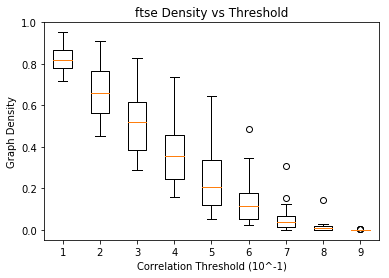

In [10]:
# plt.boxplot(density_distr)
# plt.ylabel("Graph Density")
# plt.xlabel("Correlation Threshold (10^-1)")
# plt.title("%s Density vs Threshold" % (dataset))
# plt.show()

In [ ]:
# Create graph for each date and calculate best coloring. 

coloring_array = []
valid_coloring_array = []
num_colors_array = []
date_array = []
density_array = []
threshold_array = []

count = 0
for i in np.arange(0.4, 0.8, 0.1):
    for j in range(1, int(num_examples/5)):
        
        corr_mat = corr_tensor[j*5, :, :].copy()
        corr_mat[(corr_mat > -1*i) & (corr_mat < i)] = 0
        
        G, density = make_graph(corr_mat, nodes, 'corr')
        
        count += 1
        if count % 10 == 0: 
            print("count: %d" % (count))
            
        try:
            coloring = dnx.min_vertex_coloring(G, sampler)
            valid_coloring = dnx.is_vertex_coloring(G, coloring)
        
            while not valid_coloring:
                coloring = dnx.min_vertex_coloring(G, sampler)
                valid_coloring = dnx.is_vertex_coloring(G, coloring)
                
        except Exception as err:
            print("Error on matrix %d with threshold %f" % (j*5, i))
        else:
            num_colors = np.max(list(coloring.values()))
            
            coloring_array.append(coloring)
            num_colors_array.append(num_colors)
            valid_coloring_array.append(valid_coloring)
            
            threshold_array.append(i)
            density_array.append(density)
            date_array.append(dates[j*5])
        

In [56]:
assert len(coloring_array) == len(date_array) == len(density_array) == len(threshold_array) == len(num_colors_array)

In [57]:
len(date_array)

51

In [58]:
# Create Pandas DataFrame for quantum results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array}).to_csv("grphcolor_%s_res.csv" % (dataset))

In [85]:
# Run classical graph coloring algm on the matrices that ran successfully above
from networkx.algorithms.coloring import greedy_color

coloring_array = []
valid_coloring_array = []
num_colors_array = []
density_array = []

for i in range(len(threshold_array)):
    
    # get threshold and matrix idx 
    thresh = threshold_array[i]
    idx = dates.tolist().index(date_array[i])
    
    corr_mat = corr_tensor[idx, :, :].copy()
    corr_mat[(corr_mat > -1*thresh) & (corr_mat < thresh)] = 0

    G, density = make_graph(corr_mat, nodes, 'corr')

    try:
        coloring = greedy_color(G, strategy='independent_set')
        valid_coloring = dnx.is_vertex_coloring(G, coloring)
    except Exception as err:
        print("Error on matrix %d with threshold %f" % (j*5, i))
    else:
        num_colors = np.max(list(coloring.values()))

        coloring_array.append(coloring)
        num_colors_array.append(num_colors)
        valid_coloring_array.append(valid_coloring)

        density_array.append(density)


In [86]:
assert len(coloring_array) == len(density_array) ==  len(num_colors_array) == len(valid_coloring_array)

In [87]:
# Create Pandas DataFrame for classical results
pd.DataFrame(data={"date": date_array, "threshold": threshold_array, "density": density_array,
                "coloring": coloring_array, "num_colors": num_colors_array, 
                "valid_coloring": valid_coloring_array}).to_csv("grphcolor_%s_class_res.csv" % (dataset))

In [114]:
# Compare classical vs quantum
quant_res_df = pd.read_csv("grphcolor_%s_res.csv" % (dataset))
class_res_df = pd.read_csv("grphcolor_%s_class_res.csv" % (dataset))

In [115]:
assert quant_res_df["date"].equals(class_res_df["date"])

In [117]:
quant_res = quant_res_df.loc[quant_res_df["threshold"] == 0.7].copy()
class_res = class_res_df.loc[class_res_df["threshold"] == 0.7].copy()

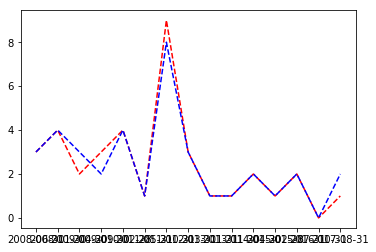

In [118]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(quant_res["date"], quant_res["num_colors"], 'r--')
plt.plot(class_res["date"], class_res['num_colors'], 'b--')

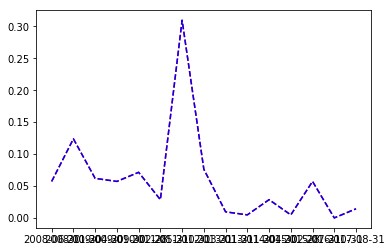

In [119]:
plt.figure(2)
plt.plot(quant_res["date"], quant_res["density"], 'r--')
plt.plot(class_res["date"], class_res["density"], 'b--')

In [122]:
quant_res

,Unnamed: 0,date,threshold,density,coloring,num_colors,valid_coloring
36,36,2008-06-30,0.7,0.057143,"{'ADM': 0, 'IHG': 0, 'AHT': 1, 'CCL': 2, 'CNA'...",3,True
37,37,2008-11-30,0.7,0.123810,"{'ADM': 0, 'CRH': 1, 'PRU': 2, 'AZN': 1, 'CCL'...",4,True
38,38,2009-04-30,0.7,0.061905,"{'ADM': 0, 'AHT': 0, 'AZN': 0, 'IHG': 0, 'CCL'...",2,True
39,39,2009-09-30,0.7,0.057143,"{'ADM': 0, 'IHG': 0, 'RIO': 1, 'CCL': 1, 'CNA'...",3,True
40,40,2010-02-28,0.7,0.071429,"{'ADM': 0, 'IHG': 0, 'IAG': 1, 'MRO': 0, 'WPP'...",4,True
41,41,2011-05-31,0.7,0.028571,"{'ADM': 0, 'AHT': 0, 'AZN': 0, 'GSK': 1, 'CCL'...",1,True
42,42,2011-10-31,0.7,0.309524,"{'ADM': 0, 'AHT': 1, 'CCL': 2, 'PRU': 3, 'RBS'...",9,True
43,43,2012-03-31,0.7,0.076190,"{'ADM': 0, 'AZN': 1, 'CCL': 1, 'CNA': 0, 'CRH'...",3,True
44,44,2013-01-31,0.7,0.009524,"{'ADM': 0, 'III': 1, 'AHT': 0, 'AZN': 0, 'CCL'...",1,True
45,45,2013-11-30,0.7,0.004762,"{'ADM': 0, 'AHT': 0, 'AZN': 0, 'CCL': 0, 'CNA'...",1,True


In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
nx.draw_networkx(G, pos=nx.spring_layout(G), font_size=14, node_color='w', ax = ax)